In [7]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU,LeakyReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, Dropout,ZeroPadding2D,MaxPool2D,concatenate
from tensorflow.keras.models import Model
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam,SGD

#Create Model
inputs = Input(shape=(32, 32, 3))
X = Conv2D(32, (3,3), strides = (1,1),padding='same',activation='elu')(inputs)
X = Conv2D(32, (3,3), strides = (1,1),padding='same',activation='elu')(X)
X = Conv2D(32, (3,3), strides = (1,1),padding='same',activation='elu')(X)
X = MaxPool2D((3,3), strides=(1,1), padding='same')(X)
X = Conv2D(32, (3,3), strides = (1,1),padding='same',activation='elu')(X)
X = Conv2D(32, (3,3), strides = (1,1),padding='same',activation='elu')(X)
X = Conv2D(32, (3,3), strides = (1,1),padding='same',activation='elu')(X)
#X = Dropout(0.5)(X)

#Inception1
conv_1 = Conv2D(32, (1,1), padding='same', activation='elu')(X)
conv_1 = Conv2D(32, (3,3), padding='same', activation='elu')(conv_1)
conv_1 = Conv2D(32, (3,3), padding='same', activation='elu')(conv_1)
conv_1 = Dropout(0.5)(conv_1)

conv_2 = Conv2D(32, (1,1), padding='same', activation='elu')(X)
conv_2 = Conv2D(32, (3,3), padding='same', activation='elu')(conv_2)
conv_2 = Dropout(0.5)(conv_2)

conv_3 = MaxPool2D((3,3), strides=(1,1), padding='same')(X)
conv_3 = Conv2D(32, (1,1), padding='same', activation='elu')(conv_3)

conv_4 = Conv2D(32, (1,1), padding='same', activation='elu')(X)

X = concatenate([conv_1,conv_2,conv_3,conv_4], axis=3)
#X = Dropout(0.5)(X)

#Inception2
conv_1 = Conv2D(32, (1,1), padding='same', activation='elu')(X)
conv_1 = Conv2D(32, (1,7), padding='same', activation='elu')(conv_1)
conv_1 = Conv2D(32, (7,1), padding='same', activation='elu')(conv_1)
conv_1 = Conv2D(32, (1,7), padding='same', activation='elu')(conv_1)
conv_1 = Conv2D(32, (7,1), padding='same', activation='elu')(conv_1)
conv_1 = Dropout(0.5)(conv_1)

conv_2 = Conv2D(32, (1,1), padding='same', activation='elu')(X)
conv_2 = Conv2D(32, (1,7), padding='same', activation='elu')(conv_2)
conv_2 = Conv2D(32, (7,1), padding='same', activation='elu')(conv_2)
conv_2 = Dropout(0.5)(conv_2)

conv_3 = MaxPool2D((3,3), strides=(1,1), padding='same')(X)
conv_3 = Conv2D(32, (1,1), padding='same', activation='elu')(conv_3)

conv_4 = Conv2D(32, (1,1), padding='same', activation='elu')(X)

X = concatenate([conv_1,conv_2,conv_3,conv_4], axis=3)
#X = Dropout(0.5)(X)


#Inception3
conv_1 = Conv2D(32, (1,1), padding='same', activation='elu')(X)
conv_1 = Conv2D(32, (3,3), padding='same', activation='elu')(conv_1)
conv_11 = Conv2D(32, (1,3), padding='same', activation='elu')(conv_1)
conv_11 = Dropout(0.5)(conv_11)
conv_12 = Conv2D(32, (3,1), padding='same', activation='elu')(conv_1)
conv_12 = Dropout(0.5)(conv_12)

conv_2 = Conv2D(32, (1,1), padding='same', activation='elu')(X)
conv_21 = Conv2D(32, (1,3), padding='same', activation='elu')(conv_2)
conv_21 = Dropout(0.5)(conv_21)
conv_22 = Conv2D(32, (3,1), padding='same', activation='elu')(conv_2)
conv_22 = Dropout(0.5)(conv_22)

conv_3 = MaxPool2D((3,3), strides=(1,1), padding='same')(X)
conv_3 = Conv2D(32, (1,1), padding='same', activation='elu')(conv_3)

conv_4 = Conv2D(32, (1,1), padding='same', activation='elu')(X)

X = concatenate([conv_11,conv_12,conv_21,conv_22,conv_3,conv_4], axis=3)


X = Conv2D(32, 3, activation='elu')(X)
X = Conv2D(64, 3, activation='elu')(X)
X = Dropout(0.5)(X)
X = AveragePooling2D(4)(X)
X = Flatten()(X)
X = Dense(256, activation='elu')(X)
outputs = Dense(100, activation='softmax')(X)

model = Model(inputs, outputs)

In [8]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard,EarlyStopping

(x_train, Y_train), (x_test, Y_test) = cifar100.load_data()
#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255
from keras.utils import to_categorical
y_train = to_categorical(Y_train,100)
y_test = to_categorical(Y_test,100)


from keras.preprocessing.image import ImageDataGenerator
aug_data=ImageDataGenerator(
        rotation_range=20,     #randomly rotate images in the range (20 degrees)
        horizontal_flip=True,  #randomly flip images
        width_shift_range=0.1, #randomly shift images horizontally (fraction of total width)
        shear_range = 0.2,     #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
        height_shift_range=0.1,#randomly shift images vertically (fraction of total height)
        zoom_range=0.2,        #Range for random zoom
        brightness_range = (0.5, 1.5))   #Range for picking a brightness shift value
aug_data.fit(x_train)

adam=Adam(learning_rate=0.001,clipnorm=1,name='adam')
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

checkpoint = ModelCheckpoint('InceptionNet_DropOut_Adam.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto',restore_best_weights=True)
hist=model.fit(aug_data.flow(x_train, y_train, batch_size=128),batch_size=128, epochs=1000, verbose=1, validation_data=(x_test, y_test),callbacks=[early,checkpoint])


Epoch 1/1000
391/391 [==============================] - ETA: 0s - loss: 3.8398 - accuracy: 0.1239
Epoch 00001: val_accuracy improved from -inf to 0.18680, saving model to InceptionNet_DropOut_Adam.hdf5
391/391 [==============================] - 46s 117ms/step - loss: 3.8398 - accuracy: 0.1239 - val_loss: 3.4790 - val_accuracy: 0.1868
Epoch 2/1000
391/391 [==============================] - ETA: 0s - loss: 3.2455 - accuracy: 0.2143
Epoch 00002: val_accuracy improved from 0.18680 to 0.26650, saving model to InceptionNet_DropOut_Adam.hdf5
391/391 [==============================] - 45s 116ms/step - loss: 3.2455 - accuracy: 0.2143 - val_loss: 3.0627 - val_accuracy: 0.2665
Epoch 3/1000
391/391 [==============================] - ETA: 0s - loss: 2.9859 - accuracy: 0.2643
Epoch 00003: val_accuracy improved from 0.26650 to 0.28010, saving model to InceptionNet_DropOut_Adam.hdf5
391/391 [==============================] - 46s 117ms/step - loss: 2.9859 - accuracy: 0.2643 - val_loss: 3.0237 - val_acc

In [9]:

# Test the model
y_true = y_test.argmax(-1)
y_pred = model.predict(x_test).argmax(-1)
# generate confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
confusion_matrix(y_true, y_pred)
# calculate prec, recall, accuracy
print("Prec: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Prec: 0.5149127966929993
Recall: 0.4948
Accuracy: 0.4948


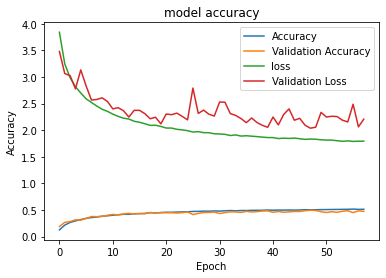

In [10]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## Cell to Load Weights and Print Results

In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU,LeakyReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense, Dropout,ZeroPadding2D,MaxPool2D,concatenate
from tensorflow.keras.models import Model
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam,SGD

inputs = Input(shape=(32, 32, 3))
X = Conv2D(32, (3,3), strides = (1,1),padding='same',activation='elu')(inputs)
X = Conv2D(32, (3,3), strides = (1,1),padding='same',activation='elu')(X)
X = Conv2D(32, (3,3), strides = (1,1),padding='same',activation='elu')(X)
X = MaxPool2D((3,3), strides=(1,1), padding='same')(X)
X = Conv2D(32, (3,3), strides = (1,1),padding='same',activation='elu')(X)
X = Conv2D(32, (3,3), strides = (1,1),padding='same',activation='elu')(X)
X = Conv2D(32, (3,3), strides = (1,1),padding='same',activation='elu')(X)
#X = Dropout(0.5)(X)

#Inception1
conv_1 = Conv2D(32, (1,1), padding='same', activation='elu')(X)
conv_1 = Conv2D(32, (3,3), padding='same', activation='elu')(conv_1)
conv_1 = Conv2D(32, (3,3), padding='same', activation='elu')(conv_1)
conv_1 = Dropout(0.5)(conv_1)

conv_2 = Conv2D(32, (1,1), padding='same', activation='elu')(X)
conv_2 = Conv2D(32, (3,3), padding='same', activation='elu')(conv_2)
conv_2 = Dropout(0.5)(conv_2)

conv_3 = MaxPool2D((3,3), strides=(1,1), padding='same')(X)
conv_3 = Conv2D(32, (1,1), padding='same', activation='elu')(conv_3)

conv_4 = Conv2D(32, (1,1), padding='same', activation='elu')(X)

X = concatenate([conv_1,conv_2,conv_3,conv_4], axis=3)
#X = Dropout(0.5)(X)

#Inception2
conv_1 = Conv2D(32, (1,1), padding='same', activation='elu')(X)
conv_1 = Conv2D(32, (1,7), padding='same', activation='elu')(conv_1)
conv_1 = Conv2D(32, (7,1), padding='same', activation='elu')(conv_1)
conv_1 = Conv2D(32, (1,7), padding='same', activation='elu')(conv_1)
conv_1 = Conv2D(32, (7,1), padding='same', activation='elu')(conv_1)
conv_1 = Dropout(0.5)(conv_1)

conv_2 = Conv2D(32, (1,1), padding='same', activation='elu')(X)
conv_2 = Conv2D(32, (1,7), padding='same', activation='elu')(conv_2)
conv_2 = Conv2D(32, (7,1), padding='same', activation='elu')(conv_2)
conv_2 = Dropout(0.5)(conv_2)

conv_3 = MaxPool2D((3,3), strides=(1,1), padding='same')(X)
conv_3 = Conv2D(32, (1,1), padding='same', activation='elu')(conv_3)

conv_4 = Conv2D(32, (1,1), padding='same', activation='elu')(X)

X = concatenate([conv_1,conv_2,conv_3,conv_4], axis=3)
#X = Dropout(0.5)(X)


#Inception3
conv_1 = Conv2D(32, (1,1), padding='same', activation='elu')(X)
conv_1 = Conv2D(32, (3,3), padding='same', activation='elu')(conv_1)
conv_11 = Conv2D(32, (1,3), padding='same', activation='elu')(conv_1)
conv_11 = Dropout(0.5)(conv_11)
conv_12 = Conv2D(32, (3,1), padding='same', activation='elu')(conv_1)
conv_12 = Dropout(0.5)(conv_12)

conv_2 = Conv2D(32, (1,1), padding='same', activation='elu')(X)
conv_21 = Conv2D(32, (1,3), padding='same', activation='elu')(conv_2)
conv_21 = Dropout(0.5)(conv_21)
conv_22 = Conv2D(32, (3,1), padding='same', activation='elu')(conv_2)
conv_22 = Dropout(0.5)(conv_22)

conv_3 = MaxPool2D((3,3), strides=(1,1), padding='same')(X)
conv_3 = Conv2D(32, (1,1), padding='same', activation='elu')(conv_3)

conv_4 = Conv2D(32, (1,1), padding='same', activation='elu')(X)

X = concatenate([conv_11,conv_12,conv_21,conv_22,conv_3,conv_4], axis=3)


X = Conv2D(32, 3, activation='elu')(X)
X = Conv2D(64, 3, activation='elu')(X)
X = Dropout(0.5)(X)
X = AveragePooling2D(4)(X)
X = Flatten()(X)
X = Dense(256, activation='elu')(X)
outputs = Dense(100, activation='softmax')(X)

model = Model(inputs, outputs)

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard,EarlyStopping

(x_train, Y_train), (x_test, Y_test) = cifar100.load_data()
#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255
from keras.utils import to_categorical
y_train = to_categorical(Y_train,100)
y_test = to_categorical(Y_test,100)

model.load_weights('../weights/InceptionNet_DropOut_Adam.hdf5')


# Test the model
y_true = y_test.argmax(-1)
y_pred = model.predict(x_test).argmax(-1)
# generate confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
confusion_matrix(y_true, y_pred)
# calculate prec, recall, accuracy
print("Prec: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))